In [611]:
import pandas as pd
import numpy as np
import os, random, glob, re

# Visualization
%matplotlib inline
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['axes.unicode_minus'] = False
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
plt.rc('font', family='Malgun Gothic')

# Modeling
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error, ndcg_score
from sklearn.preprocessing import MinMaxScaler

# Warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# Reference data
MovieLens 100K Dataset <br>
[[Data Description]](https://files.grouplens.org/datasets/movielens/ml-100k-README.txt)

In [2]:
filepath = './data/ml-100k'

In [285]:
# # user
# u_user = pd.read_csv(os.path.join(filepath, "u.user"), sep="|", encoding="iso-8859-1", header=None)
# u_user.columns = 'user id | age | gender | occupation | zip code'.replace(" ","").split("|")

# movie data
u_item = pd.read_csv(os.path.join(filepath, "u.item"), sep="|", encoding="iso-8859-1", header=None)
st = '''movie id | movie title | release date | video release date |
              IMDb URL | unknown | Action | Adventure | Animation |
              Children's | Comedy | Crime | Documentary | Drama | Fantasy |
              Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi |
              Thriller | War | Western |'''
st = re.sub(r' +', "", st).replace('\n','').split("|")[:-1]
u_item.columns = st

# rating data
u_data = pd.read_csv(os.path.join(filepath, "u.data"), sep="\t", encoding="iso-8859-1", header=None)
u_data.columns = 'user id | item id | rating | timestamp'.replace(" ","").split("|")
u_base = pd.read_csv(os.path.join(filepath, "ua.base"), sep="\t", encoding="iso-8859-1", header=None)
u_base.columns = 'user id | item id | rating | timestamp'.replace(" ","").split("|")
u_test = pd.read_csv(os.path.join(filepath, "ua.test"), sep="\t", encoding="iso-8859-1", header=None)
u_test.columns = 'user id | item id | rating | timestamp'.replace(" ","").split("|")
u_data.shape, u_base.shape, u_test.shape

((100000, 4), (90570, 4), (9430, 4))

# Load the data

In [286]:
# 943 users X 1682 items(movies)
pivot_data = u_data.iloc[:,:3].pivot_table(index='userid', columns="itemid",values='rating',aggfunc='first')
pivot_base = u_base.iloc[:,:3].pivot_table(index='userid', columns="itemid",values='rating',aggfunc='first')
pivot_test = u_test.iloc[:,:3].pivot_table(index='userid', columns="itemid",values='rating',aggfunc='first')
pivot_data.shape, pivot_base.shape, pivot_test.shape

((943, 1682), (943, 1680), (943, 1129))

In [44]:
mtx = np.array(pivot_data.fillna(0))
print(f"sparsity: {round(np.count_nonzero(mtx)/np.prod(mtx.shape)*100, 3)}(%)")

sparsity: 6.305(%)


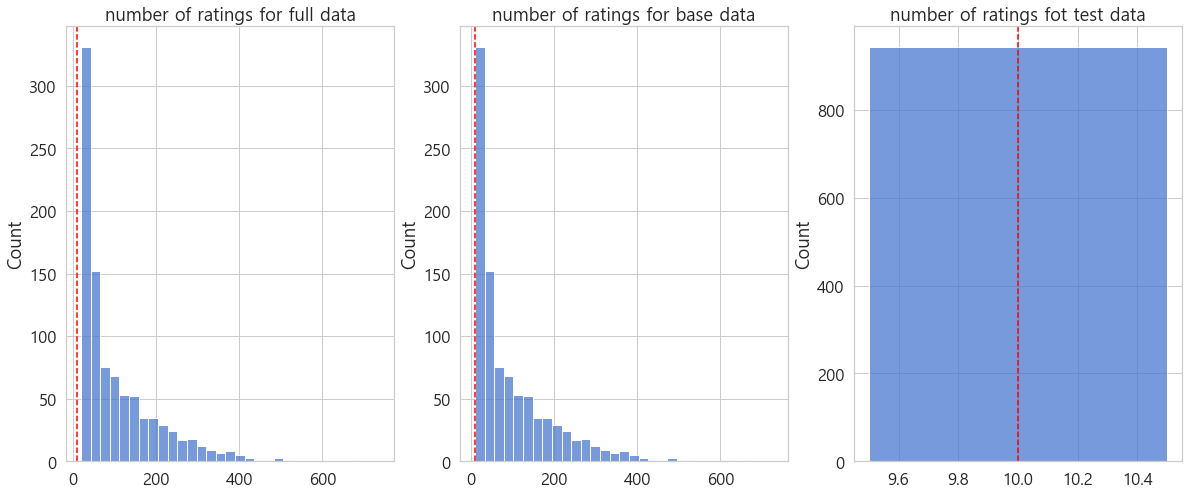

In [43]:
fig, ax = plt.subplots(figsize=(20,8), ncols=3)
sns.histplot(np.sum(np.array(pivot_data.fillna(0))!=0, axis=1), ax=ax[0]).set_title("number of ratings for full data")
ax[0].axvline(x=10, color="red",linestyle="--")
sns.histplot(np.sum(np.array(pivot_base.fillna(0))!=0, axis=1), ax=ax[1]).set_title("number of ratings for base data")
ax[1].axvline(x=10, color="red",linestyle="--")
sns.histplot(np.sum(np.array(pivot_test.fillna(0))!=0, axis=1), ax=ax[2]).set_title("number of ratings fot test data")
ax[2].axvline(x=10, color="red",linestyle="--")
plt.show()

In [89]:
for col in set(u_data.itemid.unique())-set(pivot_base.columns):
    pivot_base[col] = np.nan
pivot_base = pivot_base[sorted(pivot_base.columns)]

# MF by Truncated SVD

In [161]:
# Truncated SVD
def MF(pivot_data, k, centering=False):
    user_item = pivot_data.fillna(0)
    if centering == True:
        # Center the data
        user_mean = np.array(user_item.mean(axis=1)) # User average ratings
        user_item_mtx = np.array(user_item)-user_mean.reshape(-1,1)
    else:
        user_item_mtx = np.array(user_item)

    # Truncated SVD
    U, D, V = svds(user_item_mtx, k=k)
    D = np.diag(D)

    # prediction
    if centering == True:
        user_item_pred = pd.DataFrame(U@D@V+user_mean.reshape(-1,1)).set_index(user_item.index).set_axis(user_item.columns, axis=1)
    else:
        user_item_pred = pd.DataFrame(U@D@V).set_index(user_item.index).set_axis(user_item.columns, axis=1)
    
    return user_item_pred, U ,D, V

# Return Top-n movies
def get_genre(u_item, idx):
    genre = u_item[u_item.movieid.isin(idx)].iloc[:,5:]
    tmp = genre.apply(lambda x: genre.columns[np.where(x==1)].tolist(), axis=1)
    return tmp

def Top_n(user, top, pred, df_item, idx): 
    top_n = pd.DataFrame(pred.loc[user][idx].nlargest(top)).set_axis(['ratings'], axis=1)
    rec = df_item[df_item.movieid.isin(top_n.index)][['movieid','movietitle','releasedate']]
    rec['genre'] = pd.DataFrame(get_genre(df_item, top_n.index))
    rec = pd.merge(rec.set_index('movieid'), top_n, left_index=True, right_index=True, how="inner").sort_values('ratings', ascending=False).reset_index()
    return rec.rename(columns={'index':'movieid'})

In [393]:
# Prediction
k = 20
user_item_pred_svd, U, D, V = MF(pivot_base, k)
U.shape, D.shape, V.shape

((943, 20), (20, 20), (20, 1680))

In [394]:
# Result
user = 1
top = 5
not_seen = pivot_base.loc[user][pivot_base.loc[user].isna()].index
not_seen = pivot_data.loc[user][not_seen][pivot_data.loc[user][not_seen].notnull()].index
top_n = Top_n(user, top, user_item_pred_svd, u_item, not_seen)
top_n

,movieid,movietitle,releasedate,genre,ratings
0,202,Groundhog Day (1993),01-Jan-1993,"[Comedy, Romance]",3.572620
1,117,"Rock, The (1996)",07-Jun-1996,"[Action, Adventure, Thriller]",2.390213
2,265,"Hunt for Red October, The (1990)",01-Jan-1990,"[Action, Thriller]",2.330185
3,20,Angels and Insects (1995),01-Jan-1995,"[Drama, Romance]",1.935214
4,171,Delicatessen (1991),01-Jan-1991,"[Comedy, Sci-Fi]",1.663848


In [400]:
print("movie that has been masked\n")
print(pivot_data.iloc[0,top_n.movieid[0]-1:top_n.movieid[0]])
print(pivot_base.iloc[0,top_n.movieid[0]-1:top_n.movieid[0]])

movie that has been masked

itemid
202    5.0
Name: 1, dtype: float64
itemid
202   NaN
Name: 1, dtype: float64


#### cf.) 비교용

In [185]:
pred = pd.DataFrame(np.dot(np.dot(U, D), V)).iloc[user-1,:]

#sort + top n 
top_n = pd.DataFrame(pred.sort_values(ascending=False)[:top])
top_n = top_n.reset_index()
top_n.columns = ['movieid','rating'] # dataframe : movieindex, rating 저장

#movie title 까지 저장
top_n = top_n.merge(u_item, on='movieid', how='left')[['movieid','rating','movietitle']]
top_n

,movieid,rating,movietitle
0,49,5.619937,I.Q. (1994)
1,99,5.608336,Snow White and the Seven Dwarfs (1937)
2,167,5.120653,Private Benjamin (1980)
3,175,5.083491,Brazil (1985)
4,152,5.079847,Sleeper (1973)


In [186]:
pivot_base.iloc[0,top_n.movieid[0]-1:top_n.movieid[0]]

itemid
49    3.0
Name: 1, dtype: float64

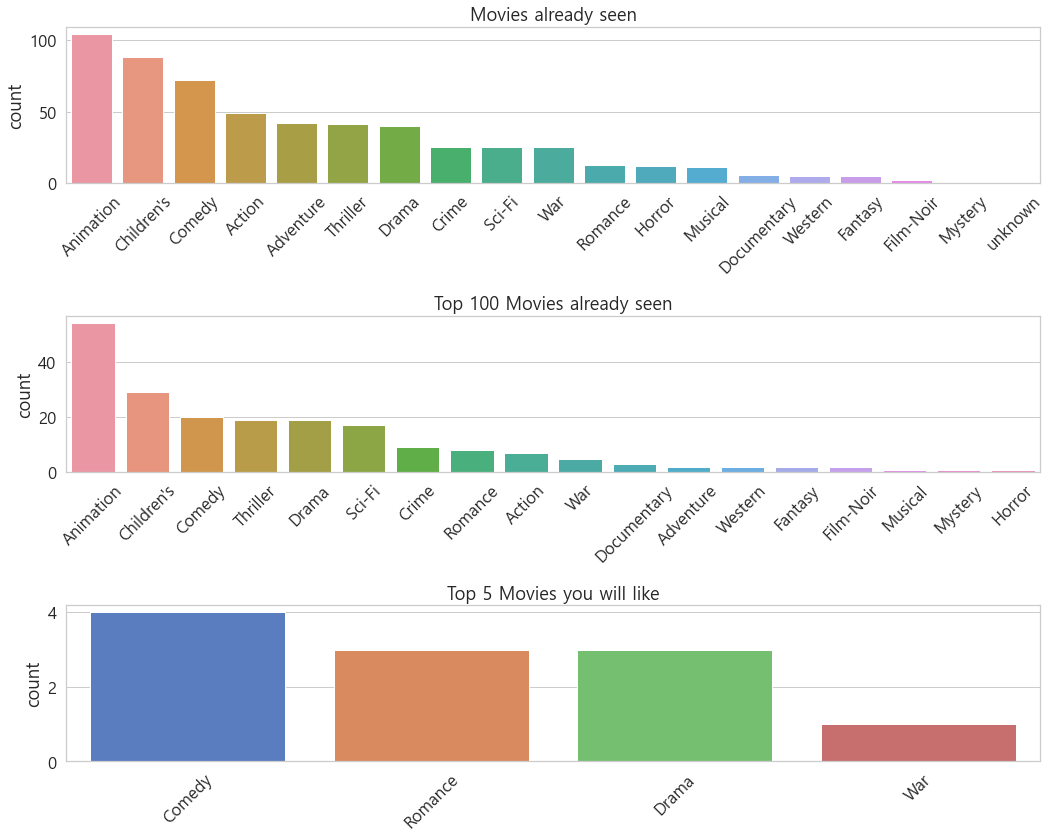

In [187]:
# movies already seen
seen = pivot_base.loc[user][~pivot_base.loc[user].isna()].index
tmp = get_genre(u_item, seen).explode()

# select top n 
n = 100
top_n = pd.DataFrame(pivot_base.fillna(0).loc[user][seen].nlargest(n)).index
tmp2 = get_genre(u_item, top_n).explode()
tmp3 = get_genre(u_item, result.movieid).explode()

# plot
fig, ax = plt.subplots(figsize=(15,12), nrows=3)
sns.countplot(tmp, order=tmp.value_counts().index, ax=ax[0]).set_title("Movies already seen")
sns.countplot(tmp2, order=tmp2.value_counts().index, ax=ax[1]).set_title(f"Top {n} Movies already seen")
sns.countplot(tmp3, order=tmp3.value_counts().index, ax=ax[2]).set_title(f"Top {top} Movies you will like")
ax[0].set_xticklabels(tmp.unique(), rotation=45)
ax[1].set_xticklabels(tmp2.unique(), rotation=45)
ax[2].set_xticklabels(tmp3.unique(), rotation=45)
plt.tight_layout()
plt.show()

# MF by ALS

In [188]:
def create_train_test(ratings, size=10):
    """
    split into training and test sets,
    remove 10 ratings from each user
    and assign them to the test set
    """
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_index = np.random.choice(
            np.flatnonzero(ratings[user]), size = size, replace = False)

        train[user, test_index] = 0.0
        test[user, test_index] = ratings[user, test_index]
        
    # assert that training and testing set are truly disjoint
    assert np.all(train * test == 0)
    return train, test

class ExplicitMF:
    """
    Train a matrix factorization model using Alternating Least Squares
    to predict empty entries in a matrix
    
    Parameters
    ----------
    n_iters : int
        number of iterations to train the algorithm
        
    n_factors : int
        number of latent factors to use in matrix 
        factorization model, some machine-learning libraries
        denote this as rank
        
    reg : float
        regularization term for item/user latent factors,
        since lambda is a keyword in python we use reg instead
    """

    def __init__(self, n_iters, n_factors, reg):
        self.reg = reg
        self.n_iters = n_iters
        self.n_factors = n_factors  
        
    def fit(self, train, test):
        """
        pass in training and testing at the same time to record
        model convergence, assuming both dataset is in the form
        of User x Item matrix with cells as ratings
        """
        self.n_user, self.n_item = train.shape
        self.user_factors = np.random.random((self.n_user, self.n_factors))
        self.item_factors = np.random.random((self.n_item, self.n_factors))
        
        # record the training and testing mse for every iteration
        # to show convergence later (usually, not worth it for production)
        self.test_mse_record  = []
        self.train_mse_record = []   
        for _ in range(self.n_iters):
            self.user_factors = self._als_step(train, self.user_factors, self.item_factors)
            self.item_factors = self._als_step(train.T, self.item_factors, self.user_factors) 
            predictions = self.predict()
            test_mse = self.compute_mse(test, predictions)
            train_mse = self.compute_mse(train, predictions)
            self.test_mse_record.append(test_mse)
            self.train_mse_record.append(train_mse)
        self.predictions = predictions
        return self  
    
    def _als_step(self, ratings, solve_vecs, fixed_vecs):
        """
        when updating the user matrix,
        the item matrix is the fixed vector and vice versa
        """
        A = fixed_vecs.T.dot(fixed_vecs) + np.eye(self.n_factors) * self.reg
        b = ratings.dot(fixed_vecs)
        A_inv = np.linalg.inv(A)
        solve_vecs = b.dot(A_inv)
        return solve_vecs
    
    def predict(self):
        """predict ratings for every user and item"""
        pred = self.user_factors.dot(self.item_factors.T)
        return pred
    
    @staticmethod
    def compute_mse(y_true, y_pred):
        """ignore zero terms prior to comparing the mse"""
        mask = np.nonzero(y_true)
        mse = mean_squared_error(y_true[mask], y_pred[mask])
        return mse
    
def plot_learning_curve(model):
    """visualize the training/testing loss"""
    linewidth = 3
    plt.plot(model.test_mse_record, label = 'Test', linewidth = linewidth)
    plt.plot(model.train_mse_record, label = 'Train', linewidth = linewidth)
    plt.xlabel('iterations')
    plt.ylabel('MSE')
    plt.legend(loc = 'best')

In [204]:
for col in set(u_base.itemid.unique())-set(u_test.itemid.unique()):
    pivot_test[col] = np.nan
pivot_test = pivot_test[sorted(pivot_test.columns)]

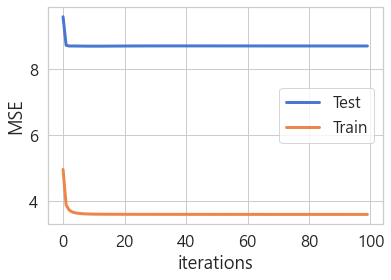

In [241]:
# Prediction
train = np.array(pivot_base.fillna(0))
test = np.array(pivot_test.fillna(0))
als = ExplicitMF(n_iters = 100, n_factors = 50, reg = 0.01)
als.fit(train, test)
plot_learning_curve(als)
user_item_pred_als = pd.DataFrame(als.predictions).set_axis(pivot_data.columns, axis=1)
user_item_pred_als.index = range(1,944)
user_item_pred_als.index.name = "userid"

In [401]:
# Result
user = 1
top = 5
not_seen = pivot_base.loc[user][pivot_base.loc[user].isna()].index
not_seen = pivot_data.loc[user][not_seen][pivot_data.loc[user][not_seen].notnull()].index
top_n = Top_n(user, top, user_item_pred, u_item, not_seen)
top_n

,movieid,movietitle,releasedate,genre,ratings
0,202,Groundhog Day (1993),01-Jan-1993,"[Comedy, Romance]",3.572620
1,117,"Rock, The (1996)",07-Jun-1996,"[Action, Adventure, Thriller]",2.390213
2,265,"Hunt for Red October, The (1990)",01-Jan-1990,"[Action, Thriller]",2.330185
3,20,Angels and Insects (1995),01-Jan-1995,"[Drama, Romance]",1.935214
4,171,Delicatessen (1991),01-Jan-1991,"[Comedy, Sci-Fi]",1.663848


In [402]:
print("movie that has been masked\n")
print(pivot_data.iloc[0,top_n.movieid[0]-1:top_n.movieid[0]])
print(pivot_base.iloc[0,top_n.movieid[0]-1:top_n.movieid[0]])

movie that has been masked

itemid
202    5.0
Name: 1, dtype: float64
itemid
202   NaN
Name: 1, dtype: float64


# Evaluation

In [520]:
# Top 5 for 943 users
top = 5
pred_svd_top_5 = {}
for user in pivot_base.index:
    not_seen = pivot_base.loc[user][pivot_base.loc[user].isna()].index
    not_seen = pivot_data.loc[user][not_seen][pivot_data.loc[user][not_seen].notnull()].index
    top_n = Top_n(user, top, user_item_pred_svd, u_item, not_seen)
    pred_svd_top_5[user] = top_n
    
pred_als_top_5 = {}
for user in pivot_base.index:
    not_seen = pivot_base.loc[user][pivot_base.loc[user].isna()].index
    not_seen = pivot_data.loc[user][not_seen][pivot_data.loc[user][not_seen].notnull()].index
    top_n = Top_n(user, top, user_item_pred_als, u_item, not_seen)
    pred_als_top_5[user] = top_n

In [489]:
top_n = pred_svd_top_5[1]
print("movie that has been masked\n")
print(pivot_data.iloc[0,top_n.movieid[0]-1:top_n.movieid[0]])
print(pivot_base.iloc[0,top_n.movieid[0]-1:top_n.movieid[0]])
print(top_n.iloc[0,4:5])

movie that has been masked

itemid
202    5.0
Name: 1, dtype: float64
itemid
202   NaN
Name: 1, dtype: float64
ratings    3.57262
Name: 0, dtype: object


In [490]:
top_n = pred_als_top_5[1]
print("movie that has been masked\n")
print(pivot_data.iloc[0,top_n.movieid[0]-1:top_n.movieid[0]])
print(pivot_base.iloc[0,top_n.movieid[0]-1:top_n.movieid[0]])
print(top_n.iloc[0,4:5])

movie that has been masked

itemid
202    5.0
Name: 1, dtype: float64
itemid
202   NaN
Name: 1, dtype: float64
ratings    2.384315
Name: 0, dtype: object


## - ndcg

In [469]:
# Ex) ndcg for user 1
user = 1
top_n = pred_als_top_5[user]
y_pred = np.array(pred_svd_top_5[user]['ratings']).reshape(1,-1)
y_true = np.array(pivot_data[list(top_n.movieid)].loc[user]).reshape(1,-1)
y_pred, y_true, ndcg_score(y_true,y_pred)

(array([[3.57261986, 2.39021288, 2.33018489, 1.93521383, 1.66384822]]),
 array([[5., 4., 4., 4., 3.]]),
 1.0)

In [468]:
y_true = [[1, 1, 1]]
y_pred = [[1.5, 1.5, 1.2]]
ndcg_score(y_true, y_pred)

1.0

In [665]:
def get_score(pred, pivot_data, pivot_base, method, threshold=4): 
    score = dict()
    for user in pivot_base.index:
        top_n = pred[user]
        y_pred = np.array(pred[user]['ratings'])
        y_true = np.array(pivot_data[list(top_n.movieid)].loc[user])
        if method == "ndcg":
            value = ndcg_score(y_true.reshape(1,-1),y_pred.reshape(1,-1))
        elif method == "rmse":
            value = np.sqrt(mean_squared_error(y_true.reshape(1,-1),y_pred.reshape(1,-1)))   
        elif method == "precision":
            scaler = MinMaxScaler(feature_range=(1,5))
            y_pred = scaler.fit_transform(pd.DataFrame(y_pred))
            y_pred = np.round(y_pred)
            numerator = len(list(filter(lambda x: x>=threshold, y_pred)))
            denominator = len(list(filter(lambda x: x>=threshold, y_true)))
            if denominator == 0:
                value = 0
            else:
                value = numerator/denominator
        score[user] = value
    return score

In [545]:
# Top 10 for 943 users
top = 10
pred_svd_top_10 = {}
for user in pivot_base.index:
    not_seen = pivot_base.loc[user][pivot_base.loc[user].isna()].index
    not_seen = pivot_data.loc[user][not_seen][pivot_data.loc[user][not_seen].notnull()].index
    top_n = Top_n(user, top, user_item_pred_svd, u_item, not_seen)
    pred_svd_top_10[user] = top_n
    
pred_als_top_10 = {}
for user in pivot_base.index:
    not_seen = pivot_base.loc[user][pivot_base.loc[user].isna()].index
    not_seen = pivot_data.loc[user][not_seen][pivot_data.loc[user][not_seen].notnull()].index
    top_n = Top_n(user, top, user_item_pred_als, u_item, not_seen)
    pred_als_top_10[user] = top_n

In [585]:
method = "ndcg"

top = 5
ndcg_svd_top_5 = get_score(pred_svd_top_5, pivot_data, pivot_base, method)
ndcg_als_top_5 = get_score(pred_als_top_5, pivot_data, pivot_base, method)

print(f"ndcg for top {top} by SVD: {round(sum(ndcg_svd_top_5 .values())/pivot_data.shape[0], 4)}")
print(f"ndcg for top {top} by ALS: {round(sum(ndcg_als_top_5 .values())/pivot_data.shape[0], 4)}")

top = 10
ndcg_svd_top_10 = get_score(pred_svd_top_10, pivot_data, pivot_base, method)
ndcg_als_top_10 = get_score(pred_als_top_10, pivot_data, pivot_base, method)

print(f"ndcg for top {top} by SVD: {round(sum(ndcg_svd_top_10.values())/pivot_data.shape[0], 4)}")
print(f"ndcg for top {top} by ALS: {round(sum(ndcg_als_top_10.values())/pivot_data.shape[0], 4)}")

ndcg for top 5 by SVD: 0.9552
ndcg for top 5 by ALS: 0.9541
ndcg for top 10 by SVD: 0.9449
ndcg for top 10 by ALS: 0.9432


## - rmse

In [1]:
method = "rmse"

top = 5
rmse_svd_top_5 = get_score(pred_svd_top_5, pivot_data, pivot_base, method)
rmse_als_top_5 = get_score(pred_als_top_5, pivot_data, pivot_base, method)

print(f"ndcg for top {top} by SVD: {round(sum(rmse_svd_top_5.values())/pivot_data.shape[0], 4)}")
print(f"ndcg for top {top} by ALS: {round(sum(rmse_als_top_5.values())/pivot_data.shape[0], 4)}")

top = 10
rmse_svd_top_10 = get_score(pred_svd_top_10, pivot_data, pivot_base, method)
rmse_als_top_10 = get_score(pred_als_top_10, pivot_data, pivot_base, method)

print(f"ndcg for top {top} by SVD: {round(sum(rmse_svd_top_10.values())/pivot_data.shape[0], 4)}")
print(f"ndcg for top {top} by ALS: {round(sum(rmse_als_top_10.values())/pivot_data.shape[0], 4)}")

## - precision

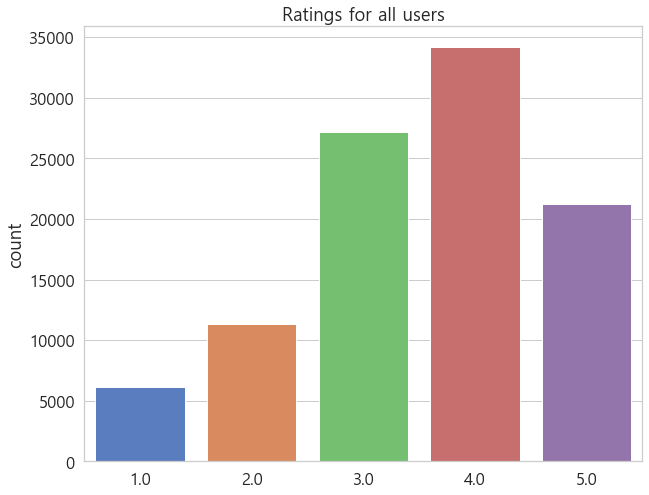

In [561]:
plt.subplots(figsize=(10,8))
sns.countplot(pivot_data.to_numpy().flatten()).set_title("Ratings for all users")
plt.show()

In [668]:
method = "precision"
threshold = 3

top = 5
precision_svd_top_5 = get_score(pred_svd_top_5, pivot_data, pivot_base, method, threshold)
precision_als_top_5 = get_score(pred_als_top_5, pivot_data, pivot_base, method, threshold)

print(f"precision for top {top} by SVD: {round(sum(precision_svd_top_5 .values())/pivot_data.shape[0], 4)}")
print(f"precision for top {top} by ALS: {round(sum(precision_als_top_5 .values())/pivot_data.shape[0], 4)}")

top = 10
precision_svd_top_10 = get_score(pred_svd_top_10, pivot_data, pivot_base, method, threshold)
precision_als_top_10 = get_score(pred_als_top_10, pivot_data, pivot_base, method, threshold)

print(f"precision for top {top} by SVD: {round(sum(precision_svd_top_10.values())/pivot_data.shape[0], 4)}")
print(f"precision for top {top} by ALS: {round(sum(precision_als_top_10.values())/pivot_data.shape[0], 4)}")

precision for top 5 by SVD: 0.5705
precision for top 5 by ALS: 0.5716
precision for top 10 by SVD: 0.6311
precision for top 10 by ALS: 0.6718


In [667]:
method = "precision"
threshold = 4

top = 5
precision_svd_top_5 = get_score(pred_svd_top_5, pivot_data, pivot_base, method, threshold)
precision_als_top_5 = get_score(pred_als_top_5, pivot_data, pivot_base, method, threshold)

print(f"precision for top {top} by SVD: {round(sum(precision_svd_top_5 .values())/pivot_data.shape[0], 4)}")
print(f"precision for top {top} by ALS: {round(sum(precision_als_top_5 .values())/pivot_data.shape[0], 4)}")

top = 10
precision_svd_top_10 = get_score(pred_svd_top_10, pivot_data, pivot_base, method, threshold)
precision_als_top_10 = get_score(pred_als_top_10, pivot_data, pivot_base, method, threshold)

print(f"precision for top {top} by SVD: {round(sum(precision_svd_top_10.values())/pivot_data.shape[0], 4)}")
print(f"precision for top {top} by ALS: {round(sum(precision_als_top_10.values())/pivot_data.shape[0], 4)}")

precision for top 5 by SVD: 0.6245
precision for top 5 by ALS: 0.6194
precision for top 10 by SVD: 0.6033
precision for top 10 by ALS: 0.646
